In [2]:
import h2o
from h2o.automl import H2OAutoML

# Start the H2O cluster (locally)
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,2 days 17 hours 41 mins
H2O_cluster_timezone:,America/Asuncion
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.4
H2O_cluster_version_age:,2 months and 5 days
H2O_cluster_name:,H2O_from_python_davidnunez_nv1rbb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.086 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [8]:
import pandas as pd
df = pd.read_csv('../df_dummizado.csv', index_col=False)

df_complaints = df[(df['Protestas'] == True)]
df_no_complaints = df[(df['Protestas'] == False)]

n_cmp = len(df_complaints.index)
n_no_cmp = len(df_no_complaints.index)
df_no_complaints = df_no_complaints.sample(int(n_cmp*3/2)) #Sample 60% no complaints 40 % complaints
balanced_df = pd.concat([df_complaints, df_no_complaints])

In [9]:
balanced_df.shape

(25575, 901)

In [11]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(balanced_df, test_size=0.2, random_state=42)
train = h2o.H2OFrame.from_python(train_data)
test = h2o.H2OFrame.from_python(test_data)
# Identify predictors and response
y = "Protestas"
x = train.columns
x.remove(y)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [12]:
# For binary classification, response should be a factor
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()

# Run AutoML for 20 base models
aml = H2OAutoML(max_models=20, seed=1)
aml.train(x=x, y=y, training_frame=train)

# View the AutoML Leader
# board
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

AutoML progress: |
08:10:25.440: AutoML: XGBoost is not available; skipping it.
08:10:25.447: _train param, Dropping bad and constant columns: [contracts.investmentProjects.id_34, parties.details.legalEntityTypeDetail buyer_15, parties.details.legalEntityTypeDetail buyer_14, parties.details.legalEntityTypeDetail buyer_13, parties.details.legalEntityTypeDetail buyer_12, parties.details.legalEntityTypeDetail buyer_11, parties.details.legalEntityTypeDetail buyer_10, parties.details.EntityType payee_1, parties.details.EntityType payee_2, parties.details.EntityType payee_3, parties.details.EntityType payee_4, contracts.investmentProjects.id_105, planning.items.classification.id.n1_1_57, Monto faltante, parties.details.EntityType candidate_2, parties.details.EntityType candidate_1, parties.details.EntityType candidate_4, parties.details.legalEntityTypeDetail candidate_1, awards.statusDetails_2, parties.details.EntityType candidate_3, parties.details.legalEntityTypeDetail candidate_2, awards.

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_1_AutoML_4_20230704_81025,0.92521,0.333355,0.906418,0.148431,0.319849,0.102303
StackedEnsemble_BestOfFamily_1_AutoML_4_20230704_81025,0.922208,0.338664,0.904044,0.152058,0.322721,0.104149
GBM_grid_1_AutoML_4_20230704_81025_model_5,0.921925,0.343228,0.902721,0.15119,0.323734,0.104804
GBM_grid_1_AutoML_4_20230704_81025_model_4,0.920096,0.344923,0.899389,0.151356,0.325476,0.105935
GBM_grid_1_AutoML_4_20230704_81025_model_1,0.918703,0.34761,0.899413,0.154785,0.326632,0.106689
GBM_4_AutoML_4_20230704_81025,0.918002,0.348734,0.89782,0.157503,0.328189,0.107708
GBM_1_AutoML_4_20230704_81025,0.916387,0.353145,0.893591,0.159567,0.331117,0.109639
GBM_3_AutoML_4_20230704_81025,0.913746,0.359552,0.889952,0.163383,0.334338,0.111782
GBM_2_AutoML_4_20230704_81025,0.911724,0.362607,0.888974,0.164527,0.336078,0.112949
GBM_5_AutoML_4_20230704_81025,0.904997,0.377306,0.880217,0.17181,0.343417,0.117936


In [13]:
preds = aml.predict(test)


stackedensemble prediction progress: |

███████████████████████████████████████████| (done) 100%


# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse,training_time_ms,predict_time_per_row_ms,algo
StackedEnsemble_AllModels_1_AutoML_4_20230704_81025,0.928657,0.326018,0.915834,0.140174,0.315338,0.0994381,8269,0.03818,StackedEnsemble
StackedEnsemble_BestOfFamily_1_AutoML_4_20230704_81025,0.92571,0.330974,0.913773,0.144884,0.318253,0.101285,4363,0.017977,StackedEnsemble
GBM_grid_1_AutoML_4_20230704_81025_model_5,0.925151,0.335143,0.912555,0.144887,0.31962,0.102157,19548,0.012366,GBM
GBM_4_AutoML_4_20230704_81025,0.923531,0.338909,0.908706,0.149604,0.323342,0.10455,14472,0.016193,GBM
GBM_grid_1_AutoML_4_20230704_81025_model_4,0.923525,0.338185,0.908712,0.145508,0.321038,0.103065,12310,0.016741,GBM
GBM_grid_1_AutoML_4_20230704_81025_model_1,0.923113,0.338722,0.910299,0.147197,0.321448,0.103329,10756,0.014547,GBM
GBM_1_AutoML_4_20230704_81025,0.920393,0.347951,0.900271,0.149768,0.327196,0.107057,18600,0.029961,GBM
GBM_3_AutoML_4_20230704_81025,0.920299,0.346956,0.902282,0.146077,0.326624,0.106683,10863,0.016959,GBM
GBM_2_AutoML_4_20230704_81025,0.917101,0.353915,0.899286,0.15392,0.330602,0.109298,10204,0.014615,GBM
DRF_1_AutoML_4_20230704_81025,0.908562,0.370865,0.897428,0.160834,0.338839,0.114812,8710,0.010074,DRF


# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## StackedEnsemble_AllModels_1_AutoML_4_20230704_81025

,False,True,Error,Rate
False,2720.0,304.0,0.1005,(304.0/3024.0)
True,376.0,1715.0,0.1798,(376.0/2091.0)
Total,3096.0,2019.0,0.1329,(680.0/5115.0)


# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

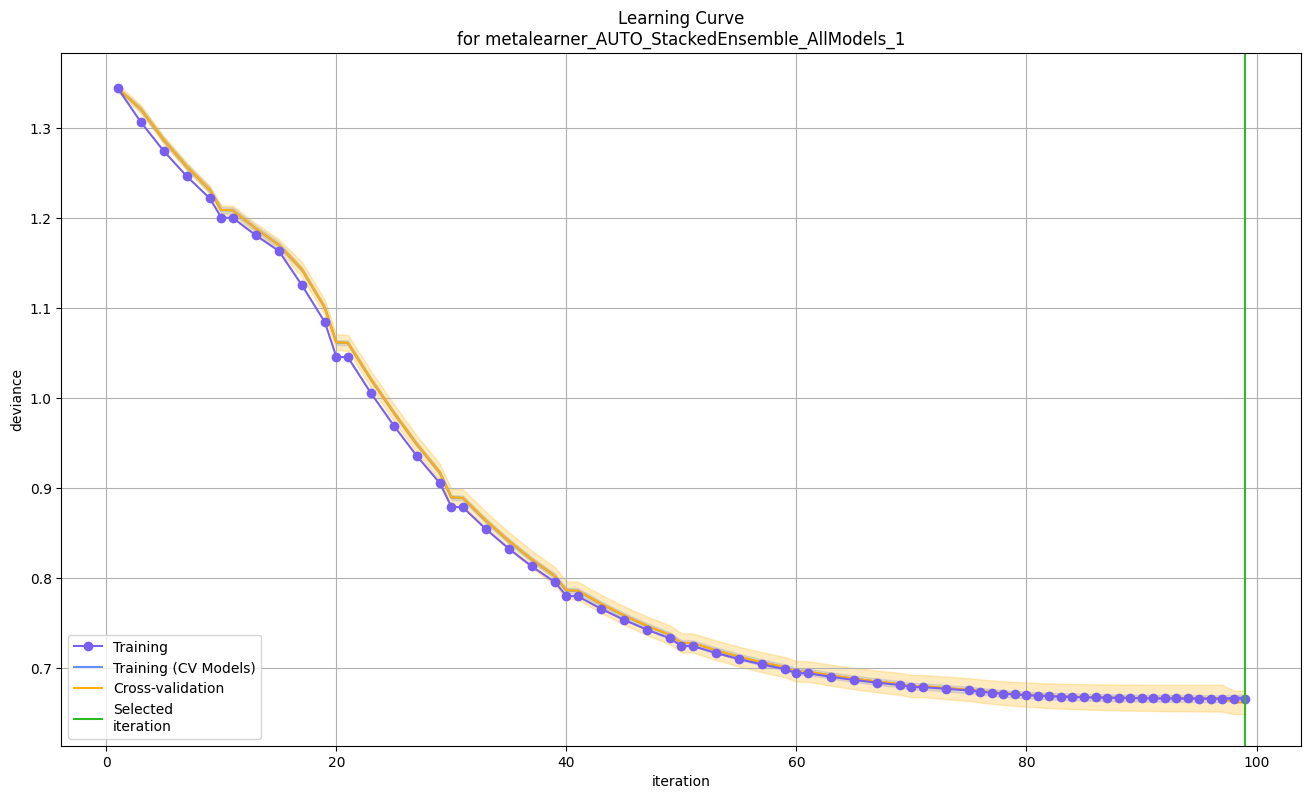

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

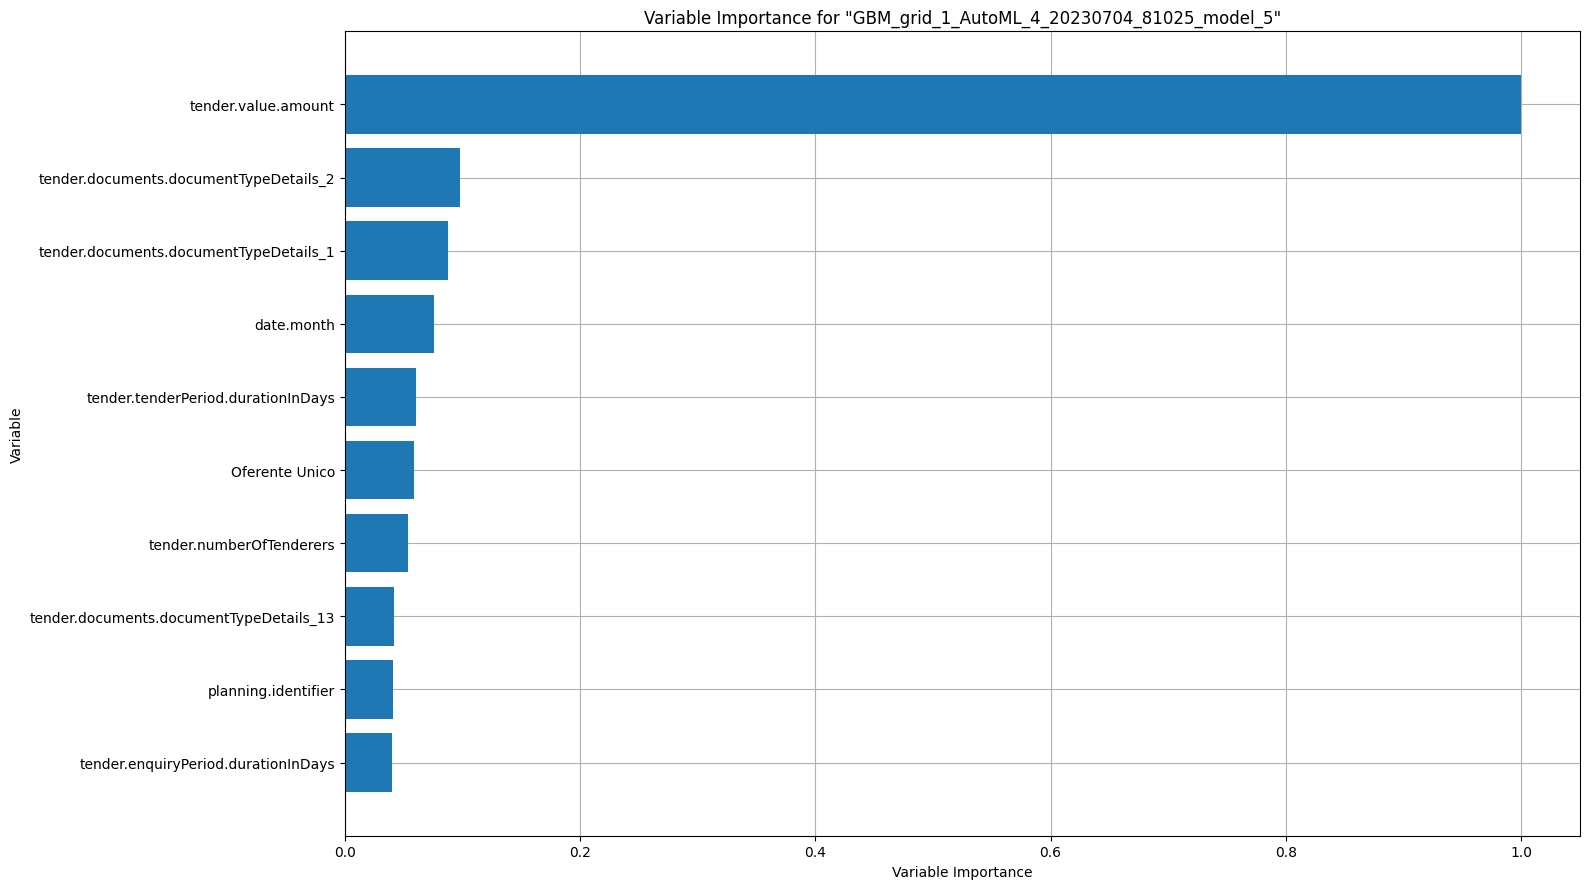

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

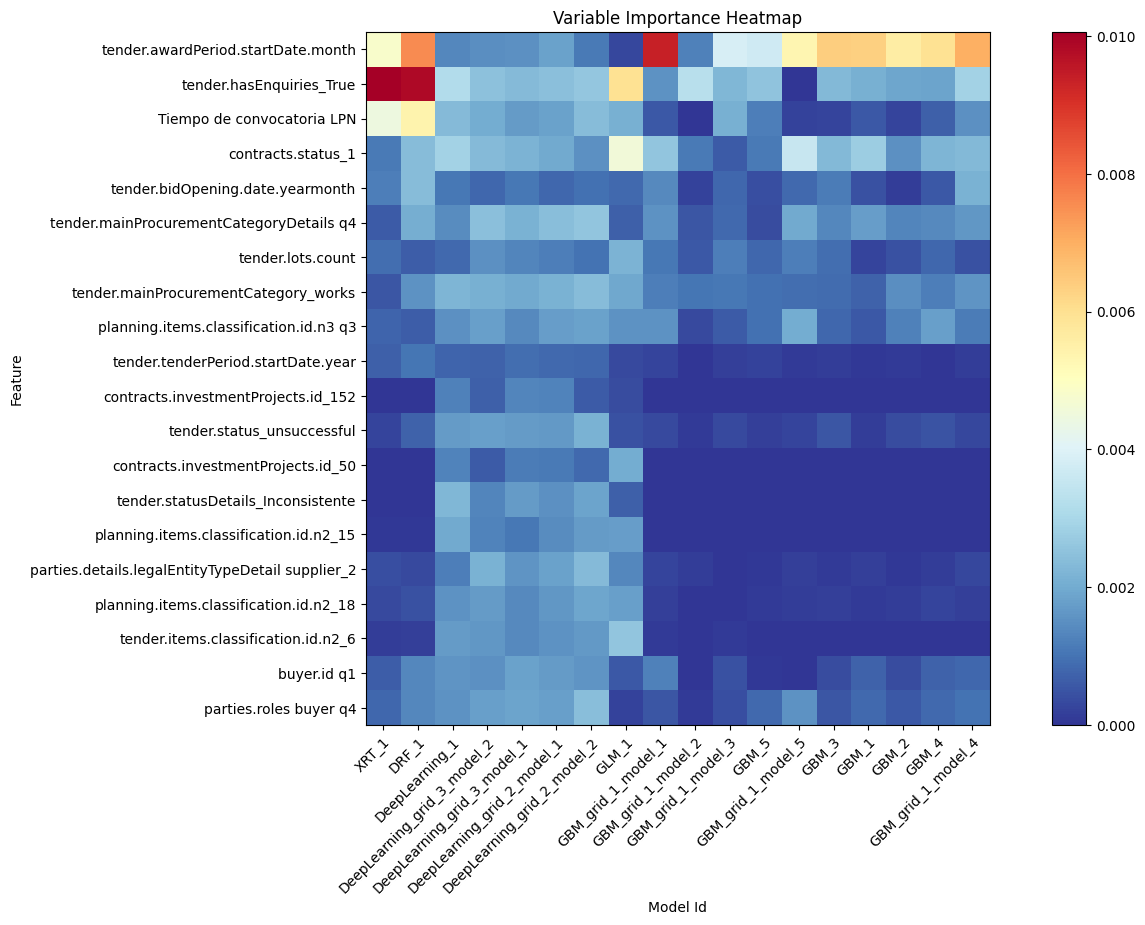

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

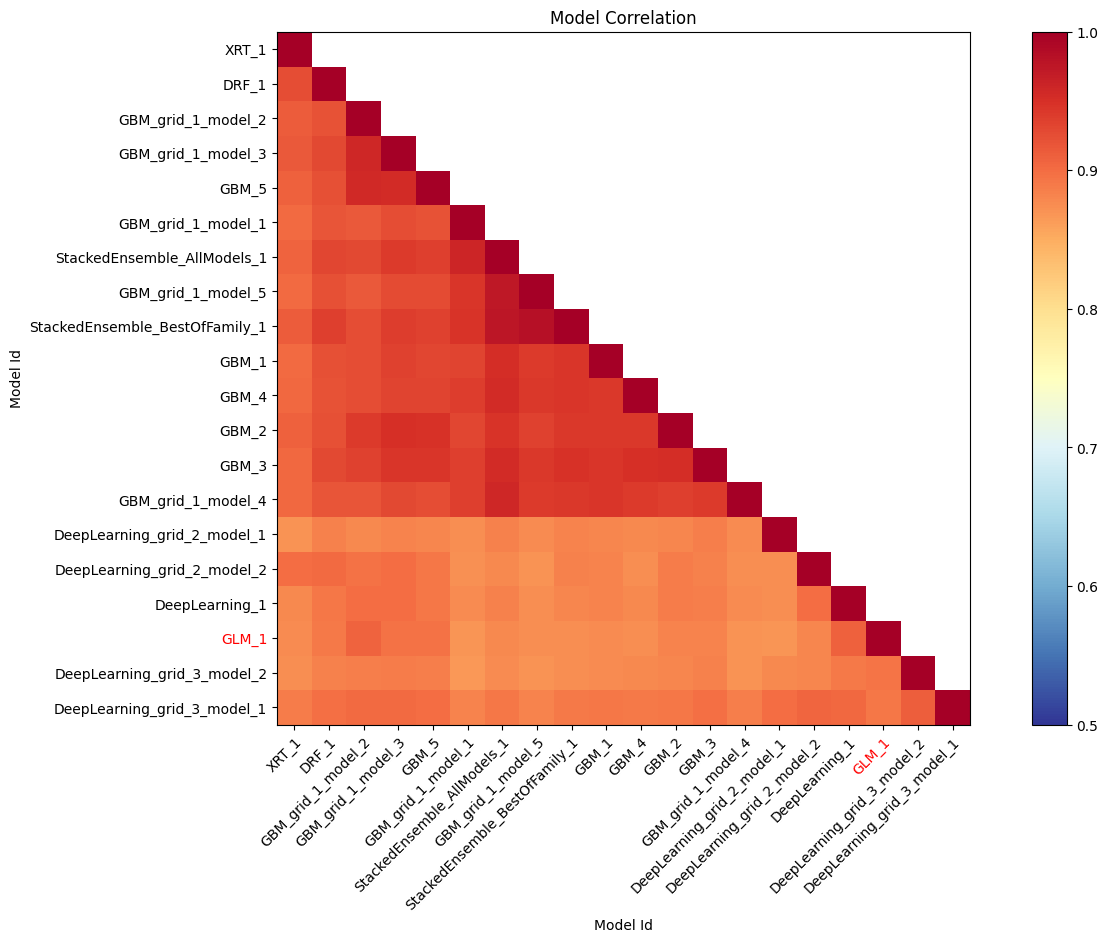

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

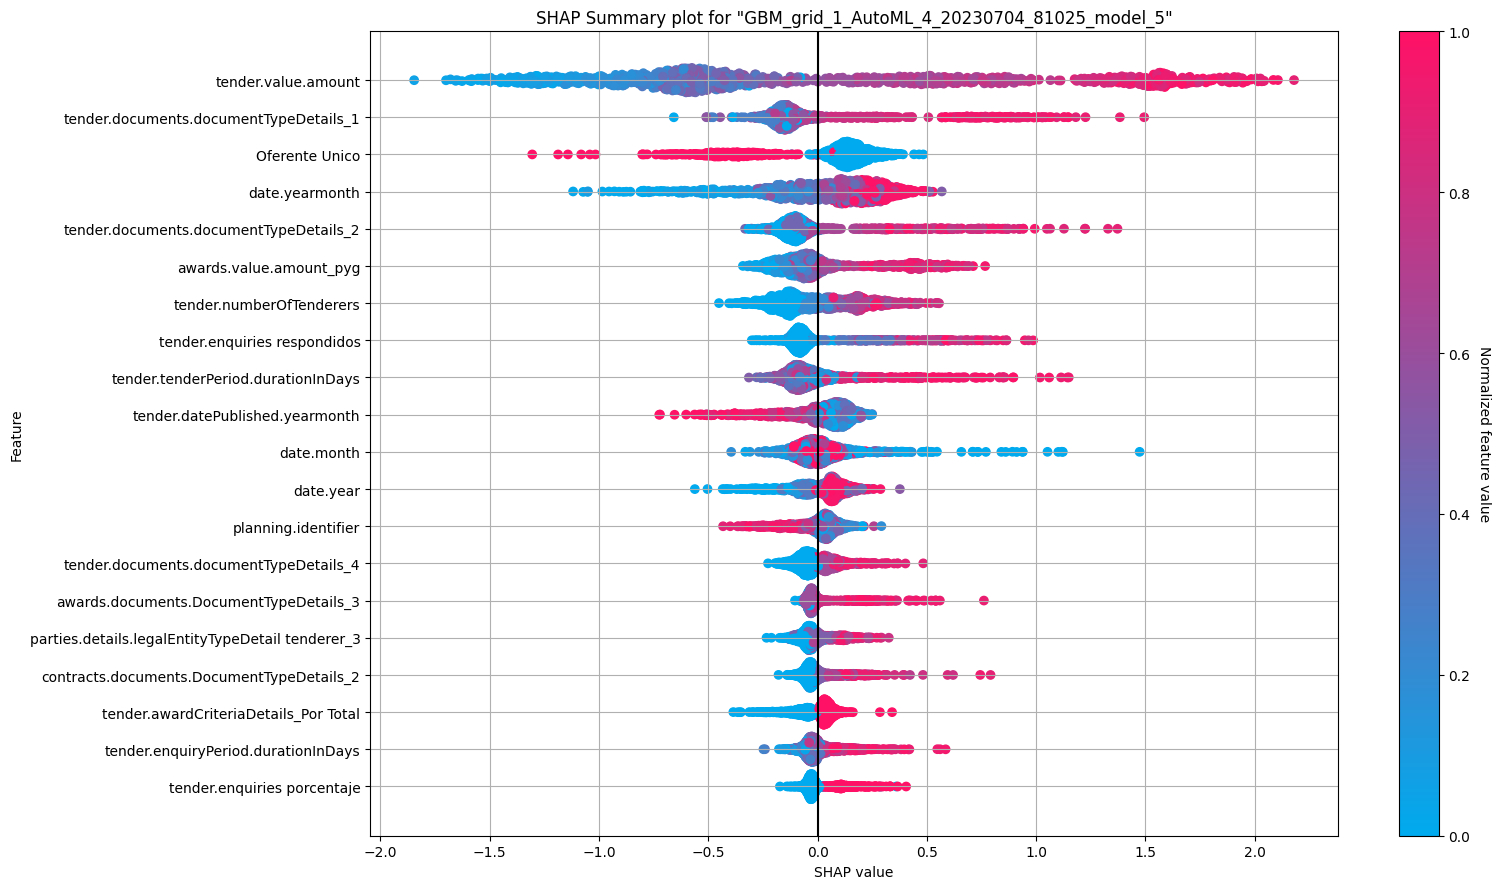

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

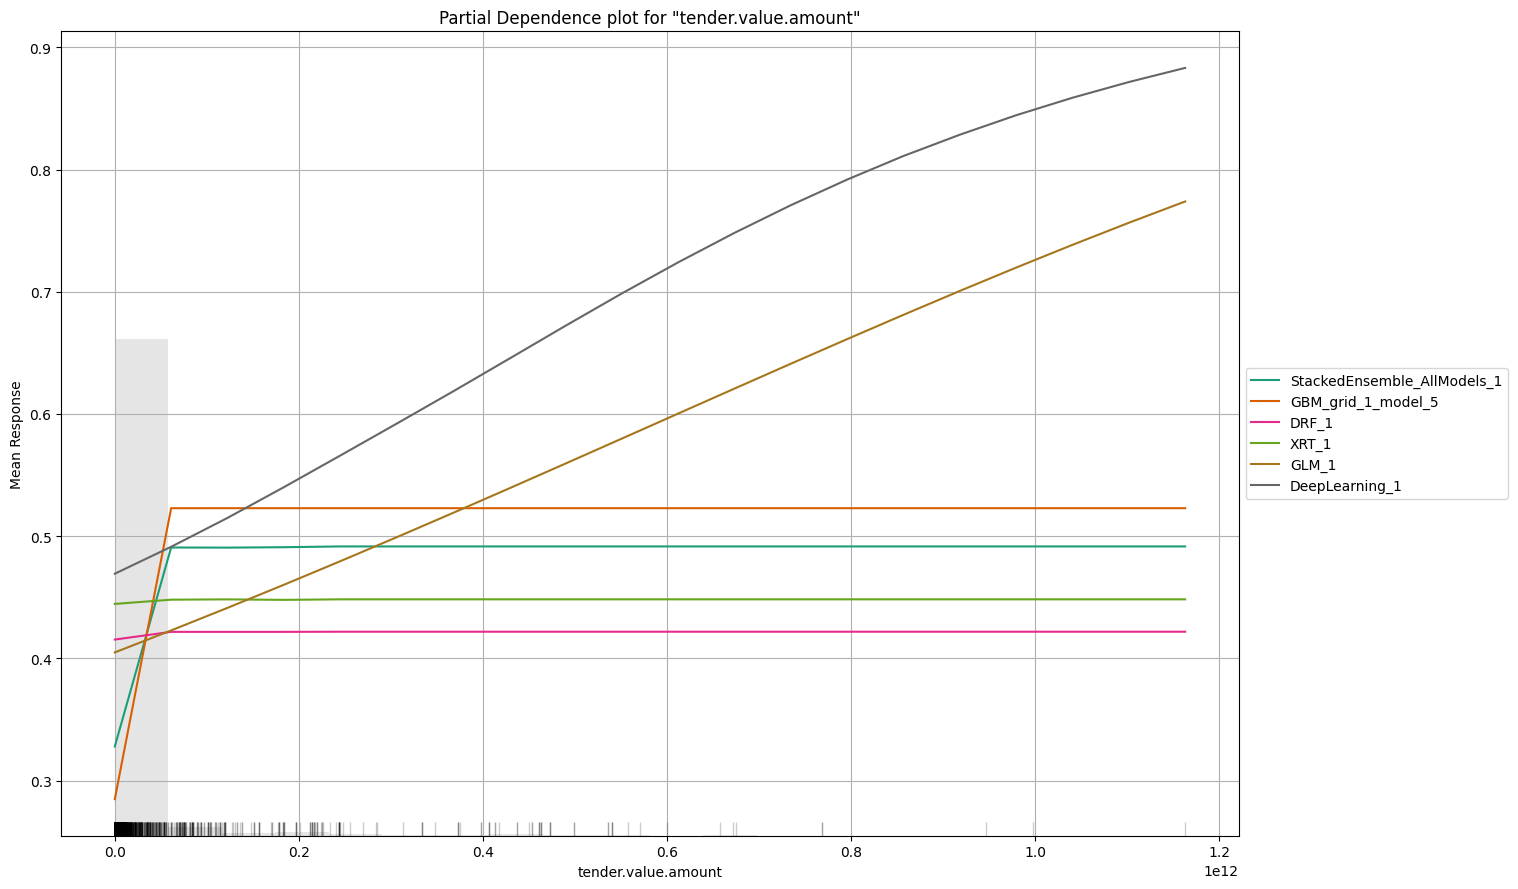

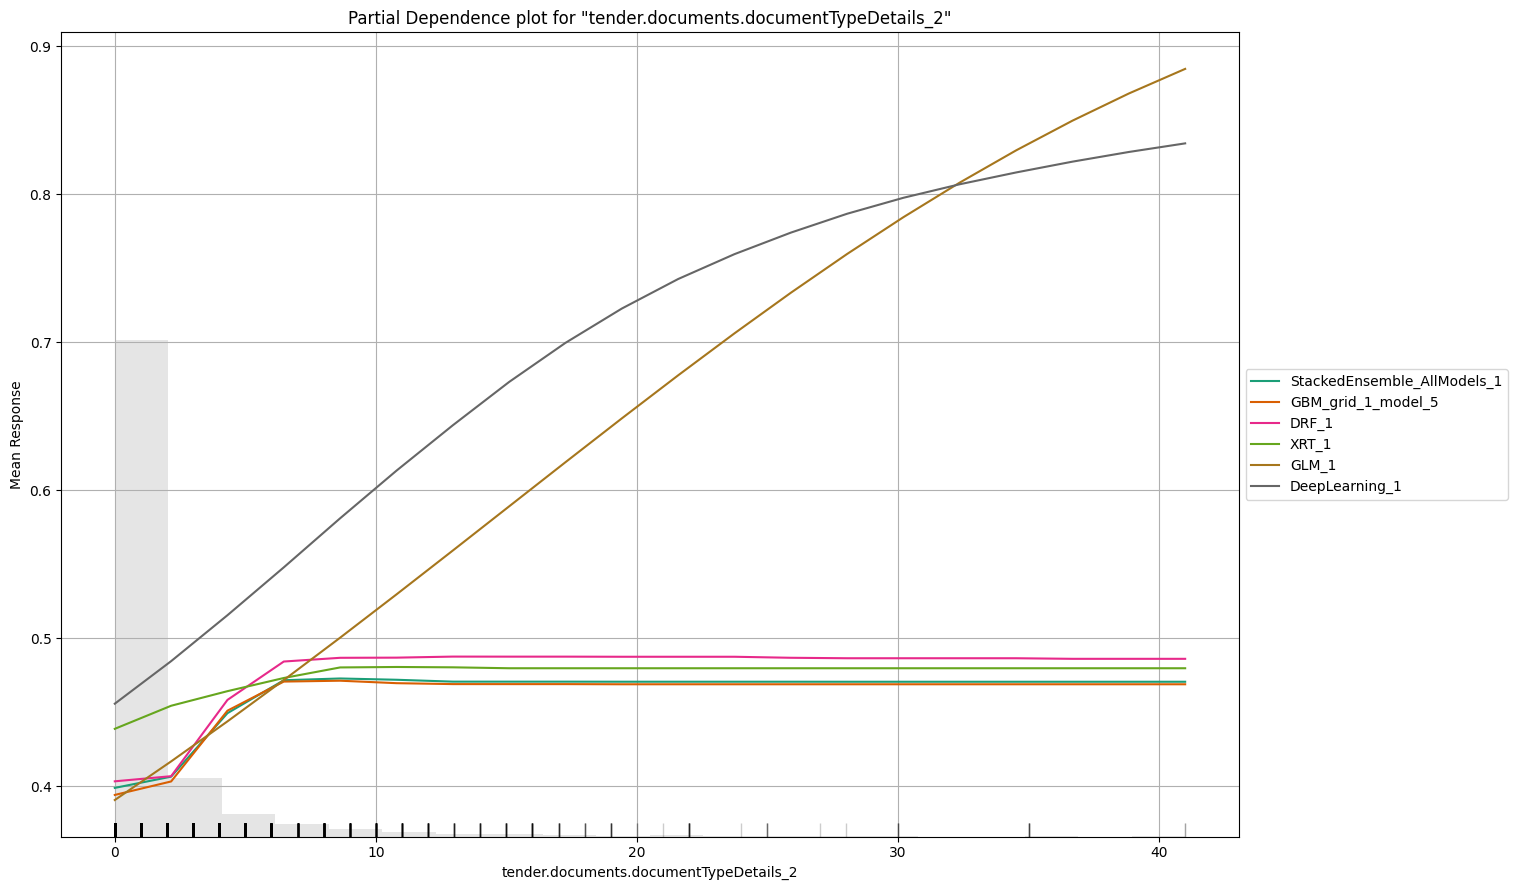

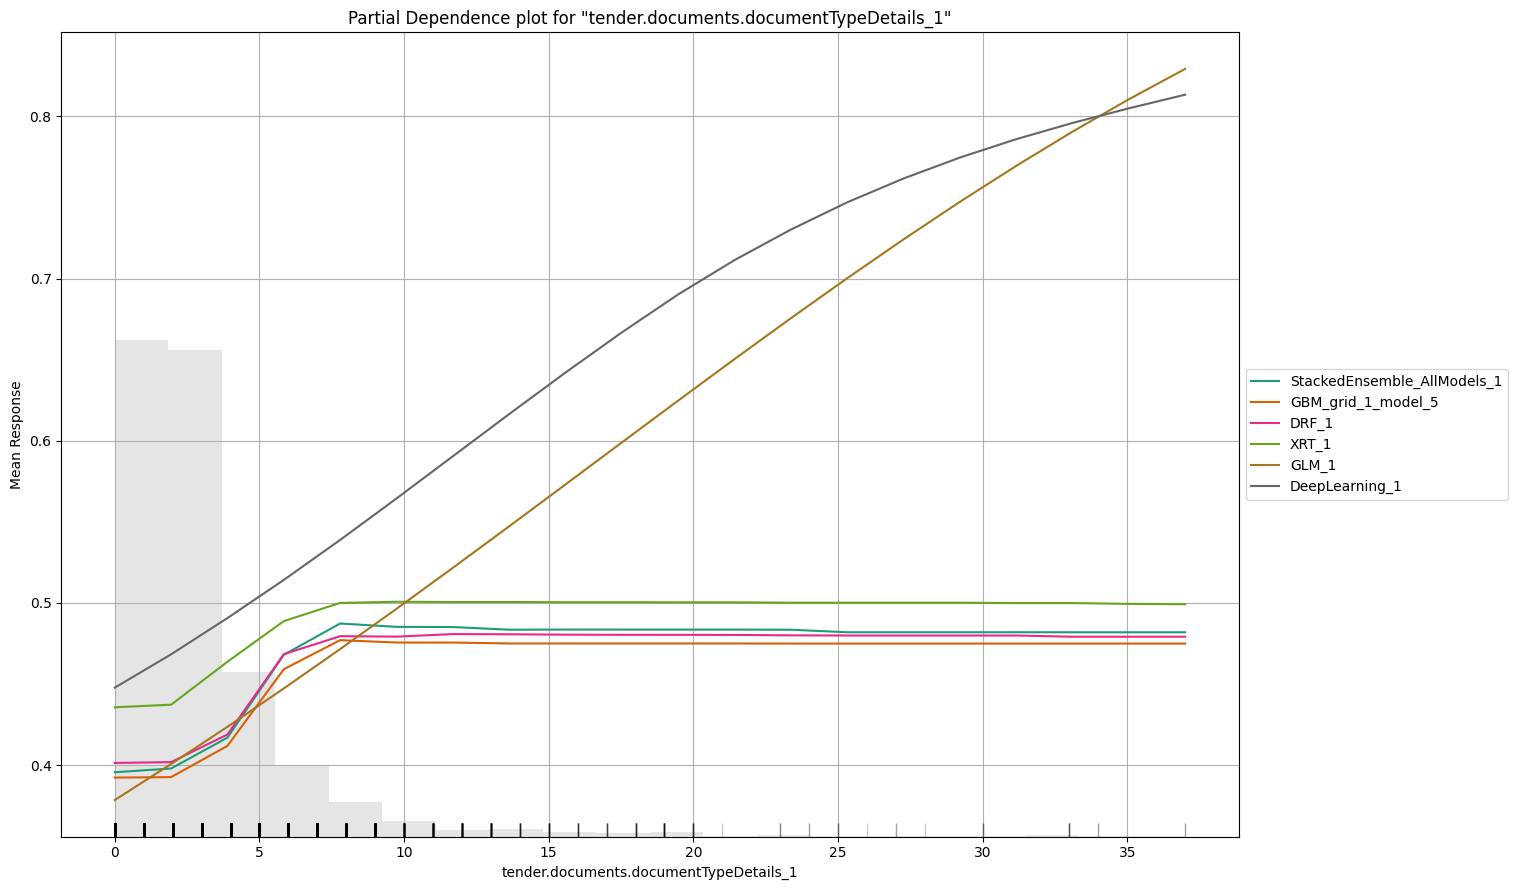

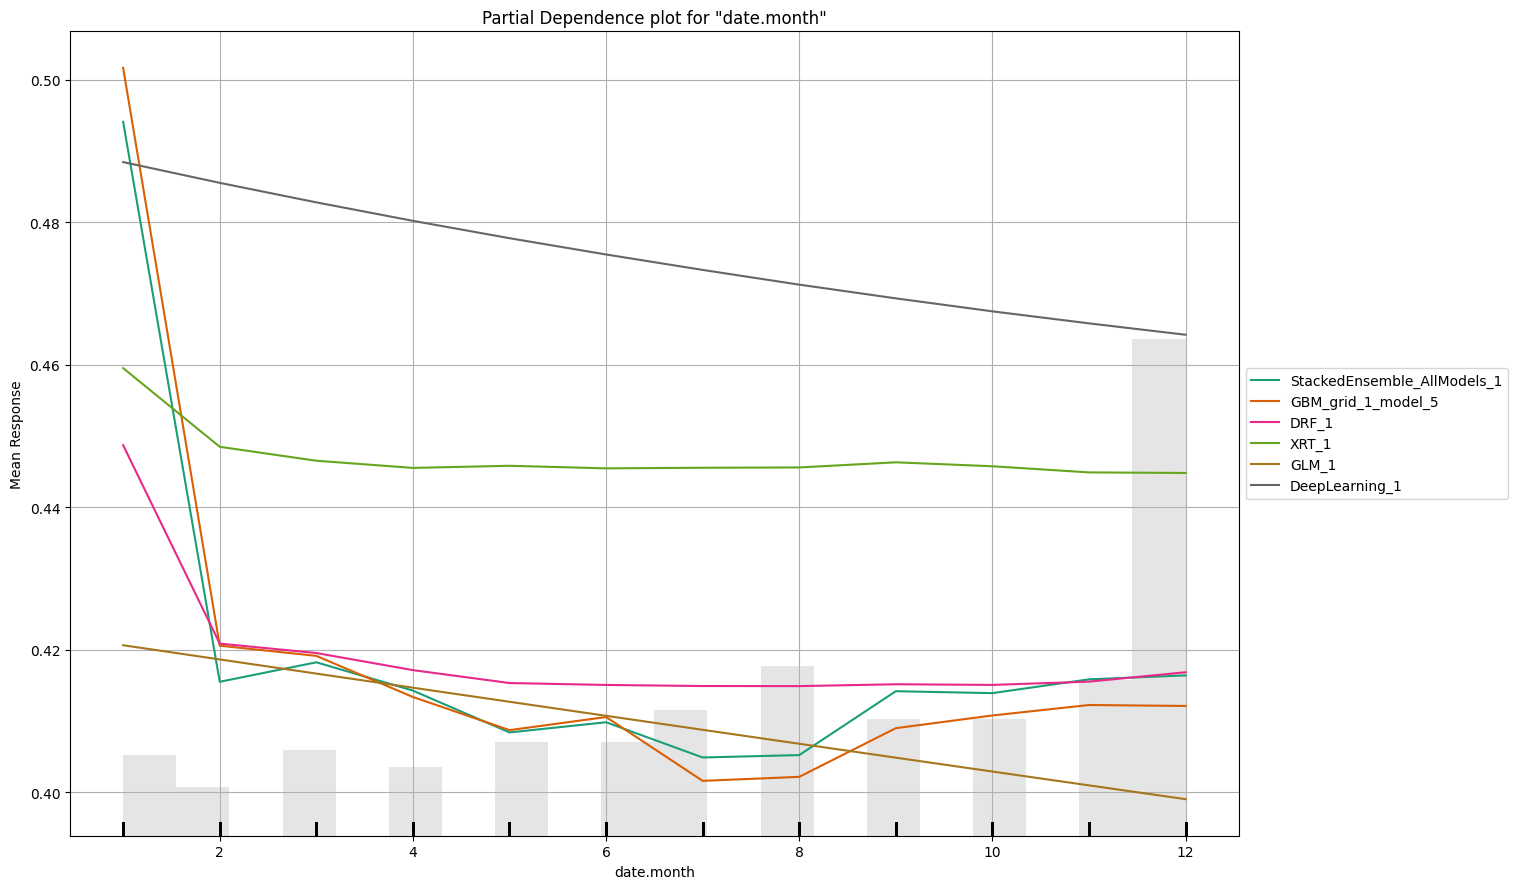

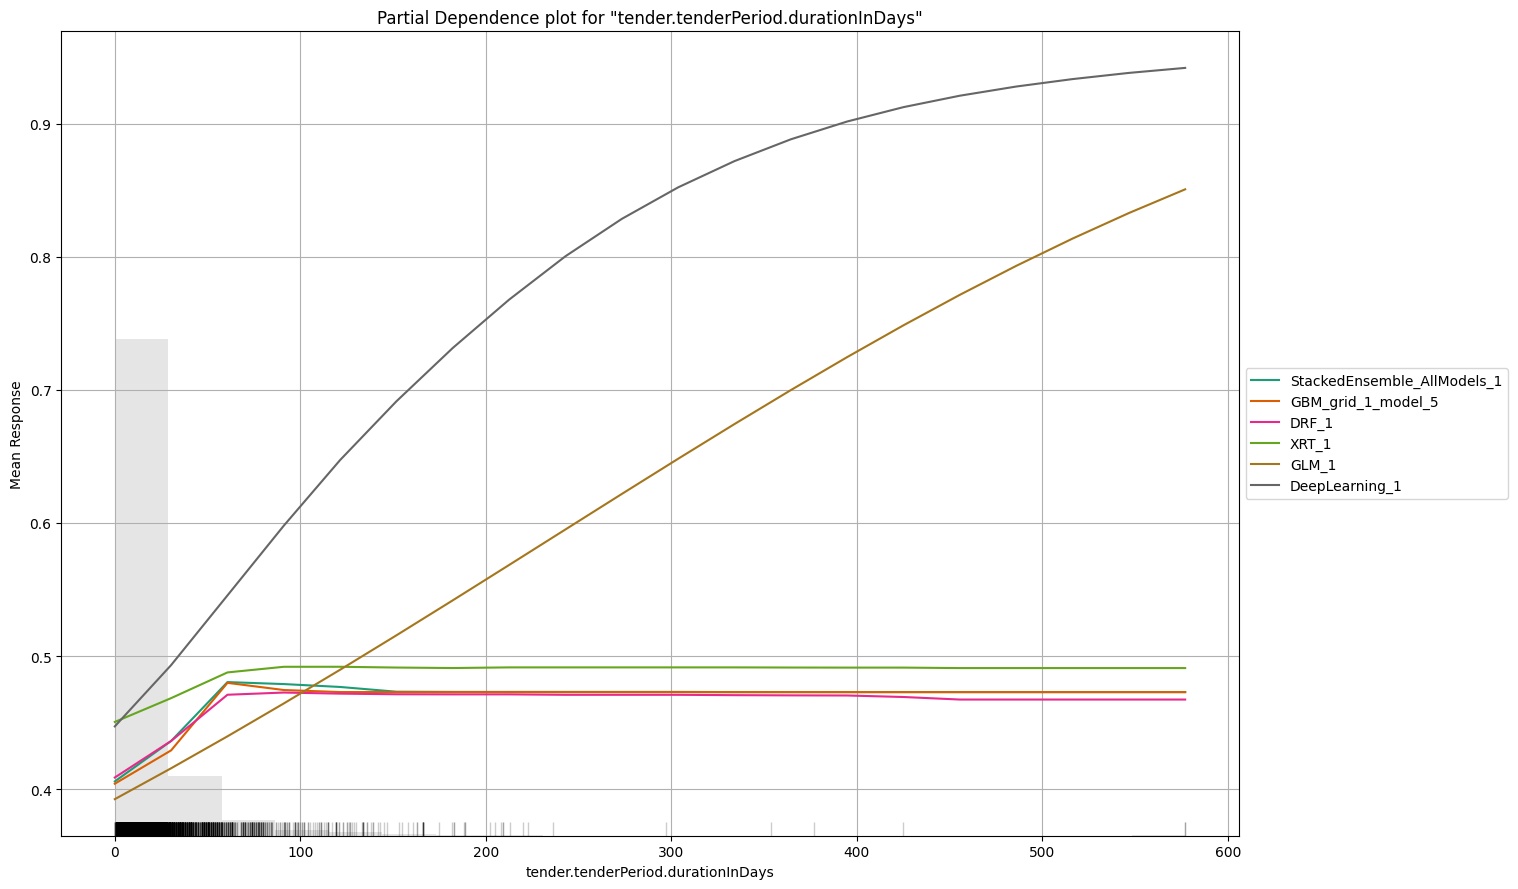

In [14]:
exa = aml.explain(test)


In [17]:
model_path = h2o.save_model(model=aml.leader, path="tmp/randomOverSamplingModel", force=True)

In [16]:
print(model_path)

/Users/davidnunez/Desktop/tesis/tesis-model/Training/tmp/initialModel/StackedEnsemble_AllModels_1_AutoML_4_20230704_81025
